## Check data cleaning for SIDEx 2023

(Hutchings et al. 2023, doi:10.18739/A2J678Z4N)

Goal to also manually check portion of one of these files. Generate list of known flags and use as training data set for data processing scripts.


#### standard_qc catches:
- most large spikes (but not all)
- also flags low-velocity "messy" data at spatial scale of GPS measurements, 5 digits / 1 m (GPS accuracy ~ 3 m)
- would be helpful to know which flags are being triggered during standard_qc run? I suspect the z-scores in check_speed may be flagging these. Would be good to not flag from check_speed if dx is on the scales of meters.

#### Next time:  
- try running individual cleaning routine to identify which checks are producing flags where they shouldn't be
- also check if adjusting current standard_qc parameters would catch more of the large spikes

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
# from scipy.spatial.distance import cdist

# sys.path.append('../../../buoy_processing/') # this is a level above GitHub folder, and outside repo
# from drifter import cleaning # drifter -- former repo name?

# try this instead:
sys.path.append('../src/')
from icedrift import cleaning

In [2]:
from pandas import Timestamp
import matplotlib
import math

<IPython.core.display.Javascript object>


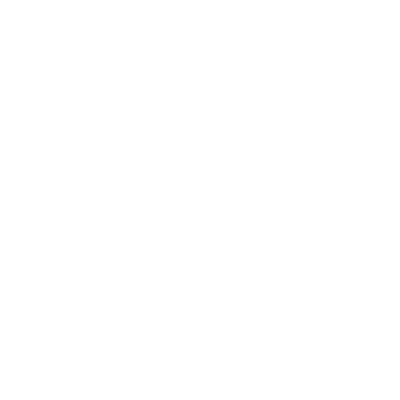

In [3]:
%matplotlib notebook
file = '../data/sidex_buoys/OSU_IT_23_300534061090050.csv'

df = pd.read_csv(file, index_col='datetime', parse_dates=True)

# crop to known error 1
# df = pd.read_csv(file, index_col='datetime', parse_dates=True)[4300:4400]

# crop to known error 2
# df = pd.read_csv(file, index_col='datetime', parse_dates=True)[4900:5000]

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(df.longitude.values, df.latitude.values, c = 'k', lw=0.5)



dates_only = df.index.floor('d')
dt_days = (dates_only - dates_only[0]).days.values
N = dt_days[-1]

# get colors from a specific colormap
cmaplist = plt.cm.Set2.colors[:-2] 

# repeat colormap X times
cmaplistext = []
for x in range(math.ceil(N / len(cmaplist))):
    cmaplistext += cmaplist
customMap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplistext, N)



ax.scatter(df.longitude.values, df.latitude.values, c = dt_days, cmap=customMap, vmin = 0, vmax = len(cmaplistext), marker='.', s=20)

# dates with known spikes
for date in [Timestamp('2021-04-02 00:00:00'),Timestamp('2021-04-03 00:00:00'),
             Timestamp('2021-06-02 00:00:00'), Timestamp('2021-06-03 00:00:00'), 
             Timestamp('2021-06-04 00:00:00')]:
    loc = df.loc[df.index[dates_only==date][0]]
    ax.scatter(loc.longitude, loc.latitude, c = 'k', marker='.', s=40, lw=0.5, zorder=10)

# loc = df.loc[Timestamp('2021-03-01 00:10:26')]
# ax.scatter(loc.longitude, loc.latitude, c = 'k', marker='.', s=10, lw=0.5, zorder=10)

In [4]:
cleaning.standard_qc?

In [5]:
df_qc = cleaning.standard_qc(df, speed_window='3D', verbose=True)

Initial size 14779 reduced to 14101
Initial size 14779 reduced to 14101


In [6]:
df_qc.flag == True

datetime
2021-02-27 13:10:24    False
2021-02-27 13:30:25    False
2021-02-27 13:40:25     True
2021-02-27 13:50:25    False
2021-02-27 14:00:54     True
                       ...  
2021-06-14 12:01:16    False
2021-06-14 12:21:49    False
2021-06-14 12:37:12    False
2021-06-14 12:56:55    False
2021-06-14 13:22:15    False
Name: flag, Length: 14779, dtype: bool

<IPython.core.display.Javascript object>


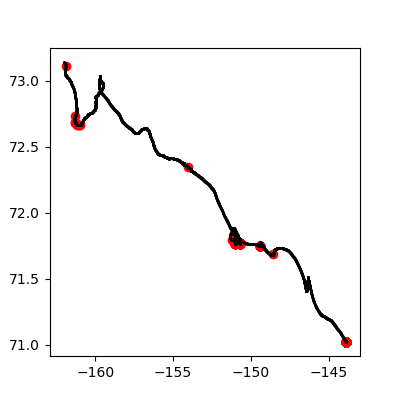

In [7]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(df_qc.longitude.values, df_qc.latitude.values, c = 'k', marker='.', ms=1, lw=0.5)
ax.scatter(df_qc.longitude.values[df_qc.flag], df_qc.latitude.values[df_qc.flag], c = 'r',)
